# 📊 Investment Opportunity Recommendation System
This notebook demonstrates how to build a recommendation system that suggests the best investment opportunities   
(sector + location) based on investor profiles and past performance data.

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import joblib
from sklearn.metrics import mean_squared_error, r2_score
import os
import warnings
warnings.filterwarnings('ignore')   
import mlflow
import mlflow.lightgbm

## Connect to the Database

In [14]:
import mysql.connector

# Database connection parameters
conn = mysql.connector.connect(
    host="localhost",
    user="Mr.Software",
    password="Simeon443@$",
    database="data_bank"
)

cursor = conn.cursor()

print("✅ Database connection established successfully.")

ProgrammingError: 1045 (28000): Access denied for user 'Mr.Software'@'localhost' (using password: YES)

## Exploratory Data Analysis

In [15]:
# Load datasets
investments = pd.read_csv("sample_investment_data.csv")
profiles = pd.read_csv("sample_investor_profiles.csv")

print("Investments shape:", investments.shape)
print("Profiles shape:", profiles.shape)
investments.head()


Investments shape: (100, 9)
Profiles shape: (100, 6)


,Investor_ID,Investor_Type,Sector,LGA,Investment_Type,Amount_NGN,Year,ROI_Percent,Status
0,INV000,Local,Mining,Lafia,DDI,444398601,2022,13.30,Stalled
1,INV001,NGO,Manufacturing,Nasarawa,FDI,316835156,2023,7.96,Stalled
2,INV002,Foreign,Energy,Lafia,FDI,282515989,2018,5.75,Active
3,INV003,NGO,Manufacturing,Nasarawa,FDI,194736815,2020,19.10,Completed
4,INV004,Local,Healthcare,Doma,FDI,102974379,2020,14.74,Completed


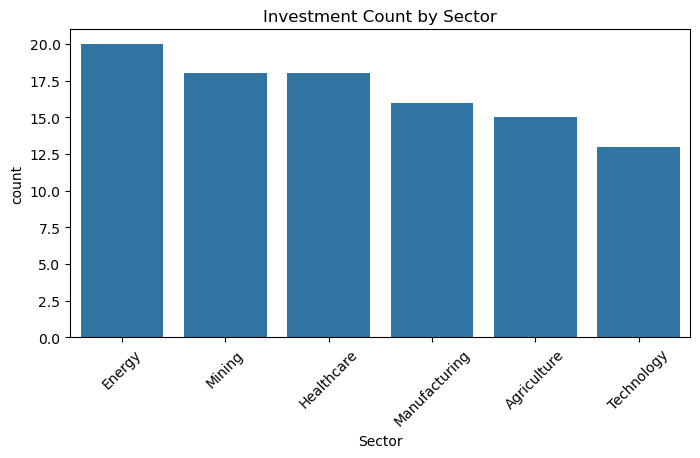

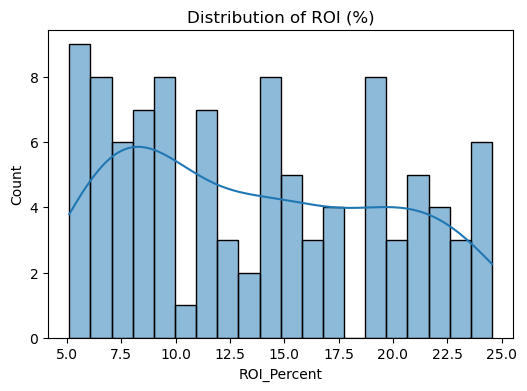

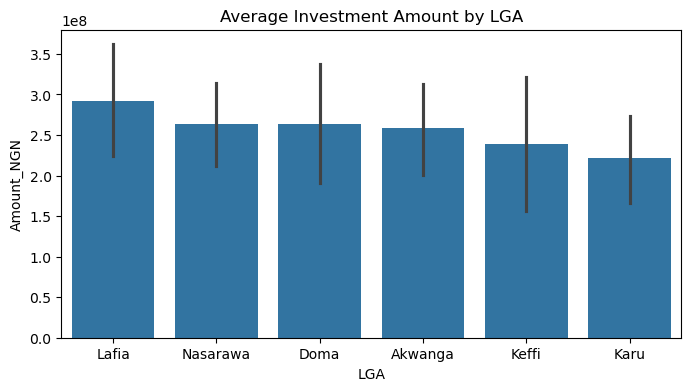

In [16]:

# Distribution of sectors
plt.figure(figsize=(8,4))
sns.countplot(x="Sector", data=investments, order=investments["Sector"].value_counts().index)
plt.xticks(rotation=45)
plt.title("Investment Count by Sector")
plt.show()

# ROI distribution
plt.figure(figsize=(6,4))
sns.histplot(investments["ROI_Percent"], kde=True, bins=20)
plt.title("Distribution of ROI (%)")
plt.show()

# Investment amount by LGA
plt.figure(figsize=(8,4))
sns.barplot(x="LGA", y="Amount_NGN", data=investments, estimator=np.mean)
plt.title("Average Investment Amount by LGA")
plt.show()


## ⚙️ Feature Engineering & Preprocessing

In [17]:

# Merge datasets on Investor_ID
df = pd.merge(investments, profiles, on="Investor_ID", how="left")

# Features & Target
X = df[['Investor_Type','Sector','LGA','Investment_Type','Country','Risk_Appetite','Preferred_Sector','Years_Active','Amount_NGN','Year']]
y = df['ROI_Percent']

# Preprocessing pipeline
categorical = X.select_dtypes(include=['object']).columns.tolist()
numeric = X.select_dtypes(include=['int64','float64']).columns.tolist()

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('num', StandardScaler(), numeric)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = lgb.LGBMRegressor(n_estimators=200, learning_rate=0.1, random_state=42)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

pipeline.fit(X_train, y_train)
print("Training Complete.")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 67
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 13
[LightGBM] [Info] Start training from score 14.004500
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

## 📈 Model Evaluation

In [18]:

from sklearn.metrics import mean_absolute_error, r2_score

y_pred = pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")


MAE: 5.29
R²: -0.68


## 💾 Save Trained Model

In [19]:

import os
os.makedirs("models", exist_ok=True)
joblib.dump(pipeline, "models/investment_recommender.pkl")
print("Model saved to models/investment_recommender.pkl")

Model saved to models/investment_recommender.pkl


## 🤖 Recommendation Demo

In [ ]:
# Example: Recommend opportunities for first investor in profiles dataset
investor_profile = profiles.iloc[0].to_dict()
print("Investor Profile:", investor_profile)

# Create test input (combine with potential sectors/LGAs)
sectors = investments["Sector"].unique()
lgas = investments["LGA"].unique()

candidates = []
for s in sectors:
    for l in lgas:
        test_case = investor_profile.copy()
        test_case["Sector"] = s
        test_case["LGA"] = l
        test_case["Investor_Type"] = "Local"
        test_case["Investment_Type"] = "FDI"
        test_case["Amount_NGN"] = 100_000_000
        test_case["Year"] = 2025
        candidates.append(test_case)

df_candidates = pd.DataFrame(candidates)
preds = pipeline.predict(df_candidates)

df_candidates["Predicted_ROI"] = preds
recommendations = df_candidates.sort_values("Predicted_ROI", ascending=False).head(5)
recommendations


Investor Profile: {'Investor_ID': 'INV000', 'Country': 'Nigeria', 'Risk_Appetite': 'High', 'Preferred_Sector': 'Technology', 'Budget_Range_NGN': '63M–387M', 'Years_Active': 5}


,Investor_ID,Country,Risk_Appetite,Preferred_Sector,Budget_Range_NGN,Years_Active,Sector,LGA,Investor_Type,Investment_Type,Amount_NGN,Year,Predicted_ROI
0,INV000,Nigeria,High,Technology,63M–387M,5,Mining,Lafia,Local,FDI,100000000,2025,15.139107
1,INV000,Nigeria,High,Technology,63M–387M,5,Mining,Nasarawa,Local,FDI,100000000,2025,15.139107
20,INV000,Nigeria,High,Technology,63M–387M,5,Healthcare,Doma,Local,FDI,100000000,2025,15.139107
21,INV000,Nigeria,High,Technology,63M–387M,5,Healthcare,Akwanga,Local,FDI,100000000,2025,15.139107
22,INV000,Nigeria,High,Technology,63M–387M,5,Healthcare,Keffi,Local,FDI,100000000,2025,15.139107


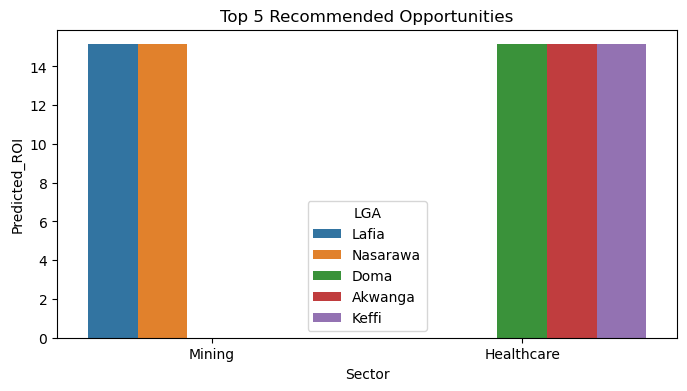

In [21]:

plt.figure(figsize=(8,4))
sns.barplot(x="Sector", y="Predicted_ROI", hue="LGA", data=recommendations)
plt.title("Top 5 Recommended Opportunities")
plt.show()


In [22]:
profiles.head()

,Investor_ID,Country,Risk_Appetite,Preferred_Sector,Budget_Range_NGN,Years_Active
0,INV000,Nigeria,High,Technology,63M–387M,5
1,INV001,India,Medium,Healthcare,82M–209M,5
2,INV002,China,Medium,Technology,94M–246M,9
3,INV003,India,Medium,Technology,10M–264M,3
4,INV004,Nigeria,Medium,Manufacturing,91M–169M,3


In [10]:
df.head()

,Investor_ID,Investor_Type,Sector,LGA,Investment_Type,Amount_NGN,Year,ROI_Percent,Status,Country,Risk_Appetite,Preferred_Sector,Budget_Range_NGN,Years_Active
0,INV000,Local,Mining,Lafia,DDI,444398601,2022,13.30,Stalled,Nigeria,High,Technology,63M–387M,5
1,INV001,NGO,Manufacturing,Nasarawa,FDI,316835156,2023,7.96,Stalled,India,Medium,Healthcare,82M–209M,5
2,INV002,Foreign,Energy,Lafia,FDI,282515989,2018,5.75,Active,China,Medium,Technology,94M–246M,9
3,INV003,NGO,Manufacturing,Nasarawa,FDI,194736815,2020,19.10,Completed,India,Medium,Technology,10M–264M,3
4,INV004,Local,Healthcare,Doma,FDI,102974379,2020,14.74,Completed,Nigeria,Medium,Manufacturing,91M–169M,3
